In [1]:
# Import the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline
from scipy.stats import loguniform
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE, VarianceThreshold
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, BaggingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier

### Read Dataset

In [ ]:
# Read the Data Set
path = 'df_faults_even.xlsx'

DF_faulty = pd.read_excel(path, index_col=0)
df_filtered = DF_faulty

In [3]:
# Prepare the data
X = df_filtered.drop(columns=['Datetime', 'Fault'])
y = df_filtered['Fault']

# Encode the target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


### FIR-SIS

In [ ]:
# Start Time
import time
start_time = time.time()

# Stratified 5-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

feature_importances = []
for train_idx, val_idx in cv.split(X_train, y_train):
    X_cv_train, X_cv_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_cv_train, y_cv_val = y_train[train_idx], y_train[val_idx]
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LGBMClassifier(random_state=42, n_jobs=-1, verbosity=-1))
    ])
    pipeline.fit(X_cv_train, y_cv_train)

    feature_importances.append(pipeline.named_steps['classifier'].feature_importances_)

# Average of Feature Importances
mean_importances = np.mean(feature_importances, axis=0)

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': mean_importances
}).sort_values(by='Importance', ascending=False)

#print(feature_importance_df)
TOP_N = 113
top_features = feature_importance_df.head(TOP_N)['Feature'].tolist()

feature_f1_scores = {}
for n in range(1, 113, 1):  # Change the step size if needed
    X_features = X_train[top_features[:n]]

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LGBMClassifier(random_state=42, n_jobs=-1, verbosity=-1))
    ])

    # Cross-Validation
    cv_results = cross_val_score(pipeline, X_features, y_train, cv=cv, scoring='f1_macro', n_jobs=-1)

    # Store the result
    mean_f1_score = np.mean(cv_results)
    feature_f1_scores[n] = mean_f1_score
    print(f"Top {n} Features: Mean F1 Score = {mean_f1_score:.4f}")

# End Time
end_time = time.time()
elapsed_time = end_time - start_time

# Convert results to DataFrame
f1_results_df = pd.DataFrame(list(feature_f1_scores.items()), columns=['Num_Features', 'F1_Score'])

Top 1 Features: Mean F1 Score = 0.2153
Top 2 Features: Mean F1 Score = 0.3634
Top 3 Features: Mean F1 Score = 0.4605
Top 4 Features: Mean F1 Score = 0.5605
Top 5 Features: Mean F1 Score = 0.5666
Top 6 Features: Mean F1 Score = 0.6393
Top 7 Features: Mean F1 Score = 0.6950
Top 8 Features: Mean F1 Score = 0.7278
Top 9 Features: Mean F1 Score = 0.7358
Top 10 Features: Mean F1 Score = 0.7530
Top 11 Features: Mean F1 Score = 0.7515
Top 12 Features: Mean F1 Score = 0.7543
Top 13 Features: Mean F1 Score = 0.7556
Top 14 Features: Mean F1 Score = 0.7664
Top 15 Features: Mean F1 Score = 0.7691
Top 16 Features: Mean F1 Score = 0.7708
Top 17 Features: Mean F1 Score = 0.7871
Top 18 Features: Mean F1 Score = 0.7882
Top 19 Features: Mean F1 Score = 0.7906
Top 20 Features: Mean F1 Score = 0.7920
Top 21 Features: Mean F1 Score = 0.7923
Top 22 Features: Mean F1 Score = 0.7919
Top 23 Features: Mean F1 Score = 0.7928
Top 24 Features: Mean F1 Score = 0.7925
Top 25 Features: Mean F1 Score = 0.7932
Top 26 Fe

Optimal number of features: 47.0
Peak F1 Score: 0.7950


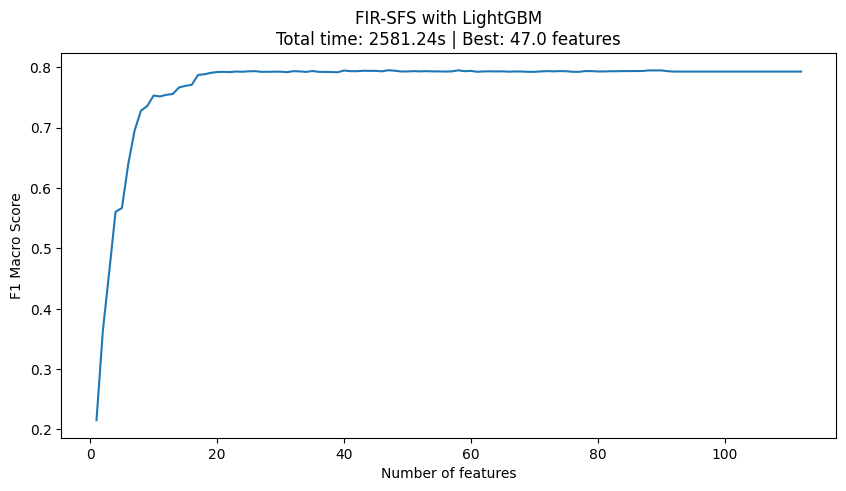

In [ ]:
# Maximum F1 score
peak_performance = f1_results_df.loc[f1_results_df['F1_Score'].idxmax()]
peak_f1_score = peak_performance['F1_Score']
optimal_num_features = peak_performance['Num_Features']
print(f"Optimal number of features: {optimal_num_features}")
print(f"Peak F1 Score: {peak_f1_score:.4f}")

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(f1_results_df['Num_Features'], f1_results_df['F1_Score'])
plt.xlabel("Number of features")
plt.ylabel('F1 Macro Score')
plt.title('FIR-SFS with LightGBM\n'
          f'Total time: {elapsed_time:.2f}s | Best: {optimal_num_features} features')
plt.show()